In [11]:
#I is the Nx1 vector containing the status of each farm
#I=0 Susceptible
#I=1 Exposed
#I=2 Infectious
#I=3 Culled

#s = Nx1 vector containing latent period of each farm 

#r = Nx1 vector containing infectious period of each farm

#A is the Nx6 matrix containing:
#column1: Index of the farm
#column2: Day number at which the farm became exposed
#column3: Latent period of the farm
#column4: Infectious period of the farm
#column5: Waiting to be culled? (1=yes, 0=no)
#column6: Time since needing to be culled

#toBeCulled is an Nx2 matrix containing information about farms that need to be Culled
#column1: Index of the farm
#column2: Time that has passed since its infectious period finished
#N.B. By infectious period, this means the time after which it can be culled.
#The farm is still infectious once the infectious period has passed.

#toBeCulledOrdered is the same matrix as above, except the farms have been ordered
#by the length of time they have been waiting to be culled

#######
#To-do#
#######
#1) Add a reported class
#2) Implement ring-culling, and decide on a way to prioritise resources
#3) Fix distance kernel - Mike's data kernel?
#4) Add in movements. Implement this separately from short range distance based infection.
#Probably use data to determine probability of that movement occurring.
#

In [12]:
import numpy as np
import random as random
import matplotlib.pyplot as plt
from matplotlib import animation
import time
import pandas as pd
import multiprocessing
import itertools
from scipy.spatial import distance
import networkx as nx
np.set_printoptions(threshold=np.nan)

countyNumber = 8

In [13]:
#Import 2010 Farm Data
farmData=pd.read_csv("Farms_2010_RSG",names=["County Number", "Parish Number", "Holding Number", 
                                               "X Coordinate", "Y Coordinate", "Number of Cattle", 
                                               "Number of Sheep"],delim_whitespace=True)
cumbData = farmData[farmData['County Number'] == countyNumber]
#cumbData = farmData
cumbData = cumbData.reset_index(drop=True)
xCumb = cumbData['X Coordinate']/100000
yCumb = cumbData['Y Coordinate']/100000
xmax = np.max(xCumb)
xmin = np.min(xCumb)
ymax = np.max(yCumb)
ymin = np.min(yCumb)
sizex = xmax-xmin
sizey = ymax-ymin
cattleFrame = cumbData['Number of Cattle']
sheepFrame = cumbData['Number of Sheep']
xcoord = xCumb - xmin #Shift to start from (0, 0)
ycoord = yCumb - ymin #Shift to start from (0, 0)
N=np.size(xcoord)

In [32]:
#Import movement data, and get movements to and from county countyNumber only.
movementData = pd.read_csv("movements_unique",header=None, delim_whitespace=True)

farmNumFrom=movementData.values[:,0]
farmNumTo=movementData.values[:,1]
weightLink=movementData.values[:,2]

county2010=farmData.values[:,0]
countyTo=np.zeros(len(farmNumTo))
for i in range(len(farmNumTo)):
    countyTo[i]=county2010[int(farmNumTo[i])-1]
    
countyFrom=np.zeros(len(farmNumFrom))
for i in range(len(farmNumFrom)):
    countyFrom[i]=county2010[int(farmNumFrom[i])-1]
movementData[3]=countyFrom
movementData[4]=countyTo

cumbMovement = []
for i in range(len(countyTo)):
    if ((countyTo[i]==countyNumber) and (countyFrom[i]==8)):
        cumbMovement.append(i)
        
cumbMovNet = movementData[(movementData[3]==8) & (movementData[4] == 8)]
cumbMovNet2 = pd.DataFrame()
cumbMovNet2['Farm From'] = cumbMovNet[0].astype(int)
cumbMovNet2['Farm To'] = cumbMovNet[1].astype(int)
cumbMovNet2['Weight'] = cumbMovNet[2]

cumbMovNet2.to_csv('cumbMovNet2.csv', index=False, header=False)
G=nx.read_edgelist('cumbMovNet2.csv', delimiter=',', nodetype=int, data=[('weight',float)], create_using=nx.DiGraph())
G.get_edge_data(7298, 9324)['weight']
farm_from=np.asarray(cumbMovNet2['Farm From']-7295)
farm_to=np.asarray(cumbMovNet2['Farm To']-7295)
weights=np.asarray(cumbMovNet2['Weight'])

In [15]:
#Calculate Euclidean distances
xinput = xcoord.values
yinput = ycoord.values
joinedinput = np.column_stack((xinput, yinput))
dist = distance.cdist(joinedinput, joinedinput, 'euclidean')

In [54]:
#Parameter values
        
psi = 0.00657
nu = 1.99*(10**(-7))
xi = 2.65
zeta = 1.80
chi = 0.403
s = np.random.negative_binomial(50, 50/55, N) #Draw latent periods
r = np.random.negative_binomial(30, 30/39, N) #Draw infectious periods

t = 0
A = np.zeros(shape=(N,6), dtype=np.int64)
#output = np.zeros(shape=(N,6))

resourceNum=10 #Number of farms that can be culled each day

In [55]:
#Calculate distance kernel
cattle = abs(cattleFrame.values)
sheep = abs(sheepFrame.values)
K = psi**2/(psi**4 + dist**4)

K[np.where(dist > 0.5)] = 0


beta1 = np.zeros(N)
beta1 = nu*(xi*(cattle)**chi + (sheep)**chi)

In [56]:
#Choose initial case
movement_infection=0
initial1 = random.randint(0,N)
initial2=initial1+1
initial3=initial2+1
initial4=initial3+1

I = np.zeros(N, dtype=np.int64)

I[initial1] = 1
I[initial2] = 1
I[initial3] = 1
I[initial4] = 1

A[initial1, ] = [initial1, 0, s[initial1], r[initial1], 0, 0]
A[initial2, ] = [initial2, 0, s[initial2], r[initial2], 0, 0]
A[initial3, ] = [initial3, 0, s[initial3], r[initial3], 0, 0]
A[initial4, ] = [initial4, 0, s[initial4], r[initial4], 0, 0]

<IPython.core.display.Javascript object>


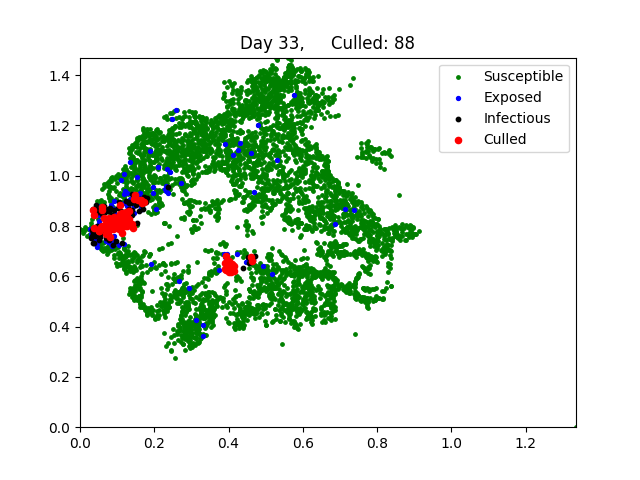

In [ ]:
%matplotlib notebook

start_time = time.time()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion

fig.show()
fig.canvas.draw()

while sum(I == 1) + sum(I == 2) > 0:

#Calculate transmission rate

    t = t + 1
    #print("Day", t, "Exposed", sum(I == 1), "Infected", sum(I == 2), "Culled", sum(I == 3))

    beta = np.zeros(N)
    for j in range(N):
        beta[j] = beta1[j]*(np.sum((zeta*(cattle[I == 2]**chi) + sheep[I == 2]**chi)*K[I == 2, j]))   

#Calculate probability of infection
    
    prob_inf = 1 - np.exp(-beta)
    
#Infect if probability is less that a uniform sample

    unif = np.random.uniform(0, 1, N)

    for i in range(0,N):
        if (unif[i] <= prob_inf[i] and I[i] == 0):
            I[i] =  1
            A[i, ] = [i, t, s[i], r[i], A[i,4], A[i,5]]
            #print("Farm", i, "Day", t)
    for j in range(len(infectind)):
        possible_contacts=farm_to[farm_from==infectind[j]]
        weight_contacts=weights[farm_from==infectind[j]]
        for i in range(len(possible_contacts)):
            if weight_contacts[i]>np.random.rand():
                I[possible_contacts[i]]=1 
                A[i, ] = [i, t, s[i], r[i], A[i,4], A[i,5]]
                movement_infection=movement_infection+1
#Update states
        
    inf = A[:,0][A[:,1] + A[:,2] == t] #Move to I state once latent period is over
    I[inf.astype(np.int64)] = 2
    
    #We have a limited number of resources available.
    #Determine which animals are past their infectious period 
    #and should be added to the list of animals that need to be culled.
    a = [A[i,0] for i in range(N)  if ((A[i,1]+A[i,2]+A[i,3] <= t) and (I[A[i,0]]==2))]
    A[a,4] = 1
    A[a,5] = t-A[a,3]-A[a,2]-A[a,1]
    toBeCulled = np.zeros(shape=(np.size(a),2), dtype=np.int64)
    toBeCulled[:,0] = a
    toBeCulled[:,1] = A[a,5]
    toBeCulledOrder = toBeCulled[np.argsort((-1*toBeCulled[:, 1]))][:,0]
    culling = A[toBeCulledOrder[0:resourceNum],0]
    I[culling] = 3
    #out = sum(output[:,1] != 0)
    
    
#Store output

    #if len(rem) > 0:
        #for i in range(0,len(rem)):
            #output[out + i,] = [rem[i], t - A[i,2] - A[i,3], xcoord[rem.astype(np.int64)[i]], ycoord[rem.astype(np.int64)[i]], cattle[rem.astype(np.int64)[i]], sheep[rem.astype(np.int64)[i]]]
     
    culledind = [i for i in range(np.size(I)) if I[i]==3]
    #print('culledind', culledind)
    #print('I[culledind]',I[culledind])
    infectind = [i for i in range(np.size(I)) if I[i]==2]
    exposedind = [i for i in range(np.size(I)) if I[i]==1]
    susceptind = [i for i in range(np.size(I)) if I[i]==0]
    #print('I',I)
    xculledplot = xinput[culledind]
    #print(xculledplot)
    yculledplot = yinput[culledind]
    xinfectplot = xinput[infectind]
    yinfectplot = yinput[infectind]
    xexposedplot = xinput[exposedind]
    yexposedplot = yinput[exposedind]
    xsusceptplot = xinput[susceptind]
    ysusceptplot = yinput[susceptind]
    
    ax.clear()
    ax.scatter(xsusceptplot, ysusceptplot, c='g', marker='o', s=6, label='Susceptible')
    ax.scatter(xexposedplot, yexposedplot, c='b', marker='o', s=8, label='Exposed')
    ax.scatter(xinfectplot, yinfectplot, c='k', marker='o', s=10, label='Infectious')
    ax.scatter(xculledplot, yculledplot, c='r', marker='o', s=20, label='Culled')
    ax.axis([0, sizex, 0, sizey])
    ax.legend()
    plt.title('Day {},     Culled: {}'.format(t, np.size(xculledplot)))
    fig.canvas.draw()
    
print("--- %s seconds ---" % (time.time() - start_time))


In [38]:
from matplotlib import animation


In [53]:
print(movement_infection)

729
